**Autor:** Carlos Alberto C. da Purificação

**E-mail:** geofisico2007@gmail.com

**Data:** 13/08/2021

Inicialmente, vamos implementar um sistema de recomendações básico e pouco robusto, baseado em similaridade entre os filmes.

In [1]:
#Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

sns.set_style('white')
%matplotlib inline

In [2]:
cols = ['user_id', 'item_id', 'rating', 'timestamp']

In [3]:
df = pd.read_csv('dataset/u.data', sep='\t', names = cols)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Quantidade de usuários e filmes únicos:

In [4]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

print('Quantidade de usuários: ' + str(n_users))
print('Quantidade de filmes: ' + str(n_items))

Quantidade de usuários: 943
Quantidade de filmes: 1682


Carregando csv com informações dos títulos e IDs dos filmes. Usaremos o ID para parear ambos os DataFrames, pois ele é uma chave estrangeira que linka uma base à outra.

In [5]:
movie_title = pd.read_table('dataset/u.item', encoding = "ISO-8859-1", names = ['item'])
movie_title.head()

,item
0,1|Toy Story (1995)|01-Jan-1995||http://us.imdb...
1,2|GoldenEye (1995)|01-Jan-1995||http://us.imdb...
2,3|Four Rooms (1995)|01-Jan-1995||http://us.imd...
3,4|Get Shorty (1995)|01-Jan-1995||http://us.imd...
4,5|Copycat (1995)|01-Jan-1995||http://us.imdb.c...


Reorganizando os atributos no dataframe `movie_title`

In [6]:
movie_title['genero'] = movie_title.item.apply(lambda x: [int(a) for a in x.split('|')[-19::]])
movie_title['title'] = movie_title.item.apply(lambda x: str(x.split('|')[1]))
movie_title['item_id'] = movie_title.item.apply(lambda x: int(x.split('|')[0]))
movie_title.drop('item', axis=1, inplace=True)
movie_title.head()

,genero,title,item_id
0,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Toy Story (1995),1
1,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",GoldenEye (1995),2
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Four Rooms (1995),3
3,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Get Shorty (1995),4
4,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",Copycat (1995),5


### Carregando dataset dos gêneros dos filmes

Existem 19 categorias de generos diferentes. Além disso, um mesmo filme pode estar em mais de uma categoria.

In [7]:
generos = pd.read_table('dataset/u.genre', names = ['genero'])
generos

,genero
0,unknown|0
1,Action|1
2,Adventure|2
3,Animation|3
4,Children's|4
5,Comedy|5
6,Crime|6
7,Documentary|7
8,Drama|8
9,Fantasy|9


In [8]:
gen = generos.genero.apply(lambda x: x.split('|')[0]).values
gen

array(['unknown', 'Action', 'Adventure', 'Animation', "Children's",
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western'], dtype=object)

In [9]:
#Função para adicionar coluna com título dos generos dos filmes.
def movie(x):
    mov = []
    for i, j in zip(x, gen):
        if i == 1:
            mov.append(j)
    return mov

In [10]:
movie_title['genero_string'] = movie_title.genero.apply(movie)
movie_title.head()

,genero,title,item_id,genero_string
0,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Toy Story (1995),1,"[Animation, Children's, Comedy]"
1,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",GoldenEye (1995),2,"[Action, Adventure, Thriller]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Four Rooms (1995),3,[Thriller]
3,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Get Shorty (1995),4,"[Action, Comedy, Drama]"
4,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",Copycat (1995),5,"[Crime, Drama, Thriller]"


In [11]:
#Aplicando merge entre os dois DataFrames, utilizando item_id como chave estrangeira

df = df.merge(right=movie_title, on='item_id')
df.head()

,user_id,item_id,rating,timestamp,genero,title,genero_string
0,196,242,3,881250949,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Kolya (1996),[Comedy]
1,63,242,3,875747190,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Kolya (1996),[Comedy]
2,226,242,5,883888671,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Kolya (1996),[Comedy]
3,154,242,3,879138235,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Kolya (1996),[Comedy]
4,306,242,5,876503793,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Kolya (1996),[Comedy]


### Criando DataFrame com base no valor médio das avaliações para cada filme.

In [12]:
aval = pd.DataFrame(df.groupby('title')['rating'].mean())
aval.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


### Adicionando coluna com quantidade de votos por filme.

In [13]:
aval['quantidade_votos'] = df.groupby('title').rating.count()
aval.head()

,rating,quantidade_votos
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


In [14]:
aval.describe()

,rating,quantidade_votos
count,1664.000000,1664.000000
mean,3.077018,60.096154
std,0.780418,80.956484
min,1.000000,1.000000
25%,2.665094,7.000000
50%,3.162132,27.000000
75%,3.651808,80.250000
max,5.000000,583.000000


Vamos usar a Regra de Sturges para obter a quantidade de bins ótima do histograma de frequências da quantidade de votos. Observando a análise descritiva acima, vemos que a a quantidade de votos mínimos que um filme recebeu é 1 e máxima é 584. Assim, a largura do histograma de frequências deve ser 584 - 1 = 583.

Ponto de partida para obter a largura dos bins: Regra de Sturges

$K = 1 + log_{10}(N)$, onde N é o número de amostras, e K é a largura de cada bin no histograma.

In [15]:
print(f'Quantidade de amostras: {aval.shape[0]}')

Quantidade de amostras: 1664


In [16]:
K = 1 + 3.322*np.log10(1664)
K

11.700671335533531

In [17]:
583/11

53.0

Assim, teremos 53 bins, cada um com largura de 11.

O histograma mostra que, de maneira geral, a maioria dos filmes têm poucos votos e a minoria tem muitos votos. Isso é interpretado através da longa calda à direita, visualizada no gráfico (distribuição Log-Normal).

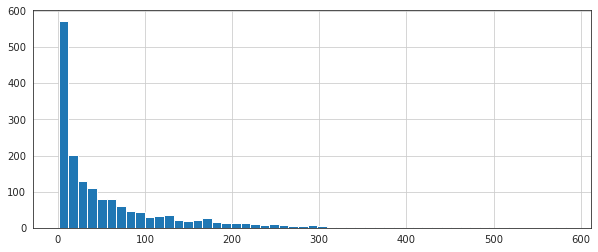

In [18]:
plt.figure(figsize=(10,4))

aval.quantidade_votos.hist(bins=53);

Já para o gráfico de distribuição de frequências exibindo o rating dos filmes abaixo, vemos que os valores 1.0, 2.0, 3.0, 4.0 e 5.0 sobressaem, o que implica dizer que muitos filmes têm a mesma avaliação. Ou seja, pegando como exemplo o filme `3 Ninjas: High Noon At Mega Mountain (1998)`, todas as pessoas o avaliou com 1 estrela. Isso se repetirá para 2, 3, 4 ou 5 estrelas.

In [19]:
df[df.title == '3 Ninjas: High Noon At Mega Mountain (1998)'].rating.nunique()

1

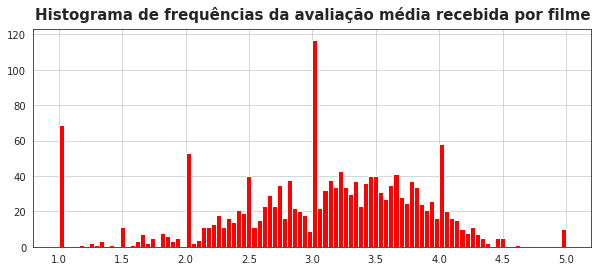

In [25]:
plt.figure(figsize=(10,4))

aval.rating.hist(bins=100, color='r')
plt.title('Histograma de frequências da avaliação média recebida por filme', fontsize = 15, fontweight='bold', pad=10)
plt.savefig('images/hist.png', bbox_inches='tight', dpi=200);

Filmes para os quais os usuários deram apenas uma tipo de estrelas (1, 2, 3, 4 ou 5)

In [26]:
filmes_unique_rating = []

for title in df.title.unique():
    if df[df.title == title].rating.nunique() == 1:
        filmes_unique_rating.append(title)

In [27]:
print(f'{len(filmes_unique_rating)} filmes, equivalente a {round(len(filmes_unique_rating)*100/df.title.nunique(),2)}\
% do total de filmes, recebem apenas um tipo de estrela (1, 2, 3, 4 ou 5!')

160 filmes, equivalente a 9.62% do total de filmes, recebem apenas um tipo de estrela (1, 2, 3, 4 ou 5!


No gráfico abaixo, vemos que a quantidade de avaliações tem relação direta com a nota avaliativa, o que implica dizer que, quanto maior é a nota dada a um filme, mais pessoas assistirão à ele e, por consequência, deixarão sua avaliação, como numa retroalimentação. Além disso, a relação parece ser mais ou menos exponencial!

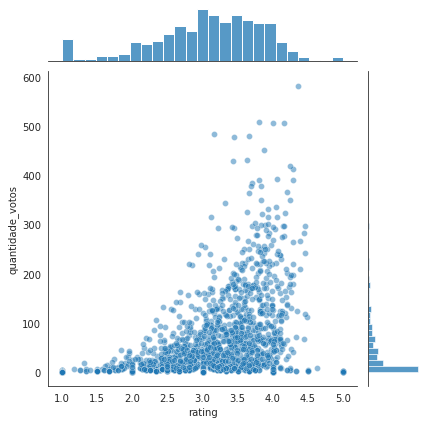

In [28]:
sns.jointplot(x='rating',y='quantidade_votos', data=aval,alpha=0.5);

Será que conseguimos modelar o gráfico acima por uma equação exponencial do tipo ${y = a\cdot exp(b \cdot x)}$ ??

In [29]:
#Obtendo parâmetros a e b da modelagem
a, _ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  aval.rating,  aval.quantidade_votos, p0 = (3,5))

print(a[0], a[1])

6.744917750778215 0.6812996717577267


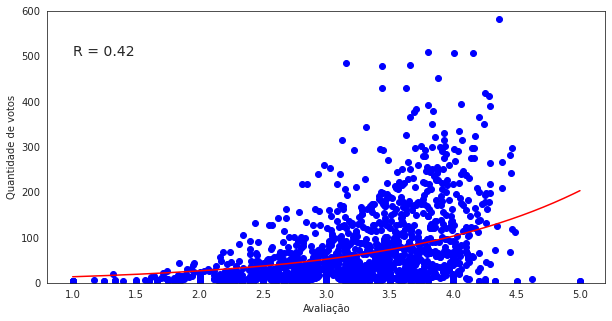

In [30]:
f, ax = plt.subplots(figsize=(10,5))

x = np.linspace(1, 5, aval.shape[0])
y = a[0]* np.exp(a[1]*x)

plt.plot(aval.rating, aval.quantidade_votos, 'b', marker='o', linestyle='')
plt.plot(x, y, 'r')
plt.xlabel('Avaliação')
plt.ylabel('Quantidade de votos')

plt.text(1, 500, 'R = ' + 
str(round(np.corrcoef(aval.quantidade_votos.values, a[0]*np.exp(a[1]*aval.rating.values))[0][1], 2)), fontsize=14)

plt.ylim(0,600);

Devido à grande dispersão, a correlação é muito baixa, indicando que é difícil realizar uma modelagem entre essas duas variáveis a partir de uma exponencial.

### Os 100 filmes que MAIS receberam votos

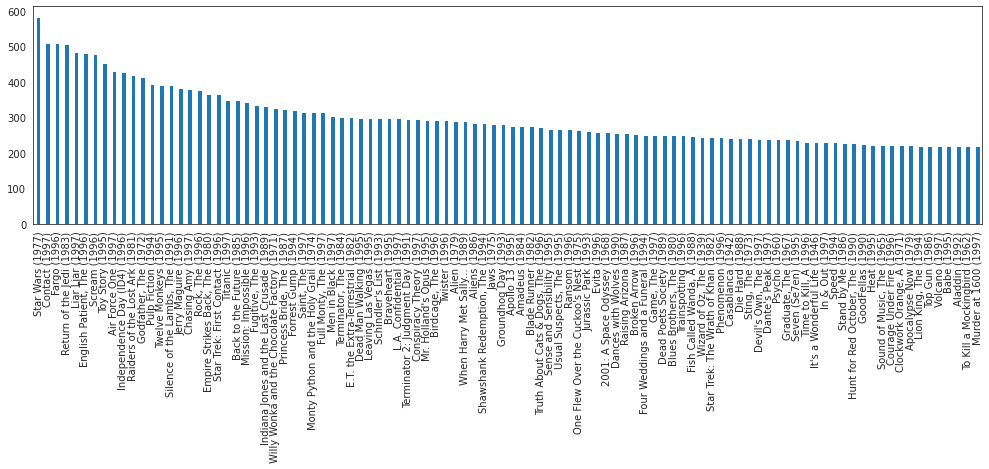

In [31]:
f, ax = plt.subplots(figsize=(17,4))

g = df.title.value_counts().sort_values(ascending=False).head(100)
g.plot.bar()
ax.set_xticklabels(labels=g.keys(), rotation=90);

In [32]:
print(f'{(df.title.value_counts() == 1).sum()} filmes foram avaliados apenas uma vez')

134 filmes foram avaliados apenas uma vez


# Recomendação de filmes por similaridade

Em sistemas de recomendações, é interessante notar a alta esparcialidade dos dados, posto que, de maneira geral, a grande maioria das pessoas verão a grande minoria dos filmes; de modo que; muitos filmes não serão avaliado por um dado usuário. Desta forma, é natural lidar com diversos valores `NaN's` (Not a number)!

In [33]:
# Criando DataFrame com usuários nas linhas e filmes nas colunas
movie = df.pivot_table(index='user_id',columns='title',values='rating')
movie.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [34]:
votos = 200
print(f'{(movie.count() >= votos).sum()} filmes recebem {votos} votos ou mais!')

118 filmes recebem 200 votos ou mais!


In [35]:
votos = 500
print(f'{(movie.count() >= votos).sum()} filmes recebem {votos} votos ou mais!')

4 filmes recebem 500 votos ou mais!


Vamos utilizar Star Wars como target

In [36]:
starwars_user_ratings = movie['Star Wars (1977)']
starwars_user_ratings.head()

user_id
1    5.0
2    5.0
3    NaN
4    5.0
5    4.0
Name: Star Wars (1977), dtype: float64

Agora, vamos obter a correlação entre duas Séries de Pandas:

In [37]:
similar_to_starwars = movie.corrwith(starwars_user_ratings)
similar_to_starwars.head()

/home/apolo/anaconda3/envs/t22/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/apolo/anaconda3/envs/t22/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [38]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [39]:
corr_starwars.sort_values('Correlation',ascending=False).head()

,Correlation
title,
Hollow Reed (1996),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
"Beans of Egypt, Maine, The (1994)",1.0
Safe Passage (1994),1.0


É possível ver que vários filmes possuem correlação de 1.0, o que não necessariamente implica que é uma boa recomendação. Pode significar que poucas pessoas avaliaram e essas poucas pessoas também assistiram Star Wars, já que foi um filme bastante assistido. Para corrigir isso e aumentar a robustes do modelo, vamos utilizar apenas filmes que tiveram pelo menos 100 avaliações.

In [40]:
corr_starwars = corr_starwars.join(aval['quantidade_votos'])
corr_starwars.head()

,Correlation,quantidade_votos
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [41]:
corr_starwars[corr_starwars['quantidade_votos'] > 100].sort_values('Correlation', ascending=False).head()

,Correlation,quantidade_votos
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Agora sim, com pelo menos 100 votos temos um melhor vislumbre de quais filmes são melhores correlacionados com Star Wars. O primeiro, neste caso, é The Empire Strikes back. Em segundo lugar vem Return of the Jedi, que também é um filme da mesma franquia. Em terceiro, vem Raiders of the Lost Ark, que é um filme de aventura e ficção científica, tal qual Star Wars.

# Sistema de Recomendação Baseada em Filtros colaborativos

## Train Test Split

Dividindo os dados em duas bases: treino e validação, com 75% e 25% dos dados, respectivamente.

In [42]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(df, test_size=0.25)

## FC baseado em memória

Pode ser dividido em duas principais grupos: **filtragem usuário-item (user-item)** e **Filtragem item-item**. 

A **filtragem usuário-item** seleciona um usuário qualquer, encontra outros usuários que são similares àquele usuário baseado nas similaridades das avaliações, e recomenda itens que estes usuários também gostaram.

Em contrapartida, **Filtragem item-item** seleciona um item qualquer, encontra usuários que gostaram daquele item e busca itens que estes usuários ou usuários similares também gostaram. Seleciona itens e dá como resposta (recomendações) outros itens.


* *Filtragem colaborativa Item-Item*: “usuários que gostaram deste item também gostaram daquele”
* *Filtragem Colaborativa usuário-Item*: “usuários que são similares à você, também gostaram disto aqui”

Em ambos os casos, criamos uma matriz usuário-item com toda a base de dados. Uma vez que separamos os dados em teste e treino, precisaremos criar duas matrizes ``[943 x 1682]``, com todos os usuários e todos os filmes.

A métrica de distância comumente utilizada em sistemas de recomendações é a *similaridade dos cossenos*, onde as avaliações são vistas como vetores no espço de dimensões ``n`` e a similaridade é calculada baseando-se no ângulo entre estes vetores. 

A similaridade entre cossenos para os usuários *a* e *m* pode ser calculada usando a fórmula abaixo, através do produto escalar entre o vetor do usuário *$ u_k$* e o vetor do usuário *$u_a$* dividido pelo produto entre as normas euclidianas dos vetores.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>

Para obter a similaridade entre os itens *m* and *b*, faz-se:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

Primeiro passo é criar a matriz usuário-item. Cria-se uma matriz de zeros com o numpy.zeros, com dimensões igual à (n_user, n_items). Cada entrada da matriz (i, j) será igual  ao valor da avaliação. Por exemplo, a primeira instância tem par user_id = 196 e item_id = 242, com rating = 3; ou seja; a entrada (196, 242) terá valor 3.

In [43]:
#mostrando a primeira instância
df.loc[[0]]

,user_id,item_id,rating,timestamp,genero,title,genero_string
0,196,242,3,881250949,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Kolya (1996),[Comedy]


In [44]:
#Criando duas matrizes usuário-item, uma para treinamento e a outra para teste
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

val_data_matrix = np.zeros((n_users, n_items))
for line in val_data.itertuples():
    val_data_matrix[line[1]-1, line[2]-1] = line[3]

In [45]:
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

Próximo passo é realizar predições. Já temos as matrizes de similaridades: `user_similarity` e `item_similarity`. Assim, podemos realizar predições aplicando a seguinte fórmula para a filtragem colaborativa baseada em usuário:

$$\large\hat{x}_{k, m}=\bar{x}_{k} + \frac{\sum\limits_{u_a}sim_u(u_k,u_a)(x_{a,m} - \bar{x}_{u_a})}{\sum\limits_{u_a}|sim_u(u_k, u_a)|}$$

Pode-se olhar para as similaridades entre os usuários *k* e *a* como pesos que são multiplicados pelas avaliações de um usuário similar *a*, corrigido pela avaliação média daquele usuário. É necessário normalizar, de modo que as avaliações permaneçam entre 1 e 5. Finalmente, soma-se as avaliações médias para o usuário que estamos tentando realizar a predição.

A ideia é que alguns usuários tendem sempre a avaliarem os filmes muito positivamente ou muito negativamente. Dessa forma, a diferença relativa entre as avaliações desses usuários é mais importante do que o valor absoluto das avaliações. por exemplo: suponha que o usuário *k* dê 4 estrelas para seus filmes favoritos e 3 estrelas para todos os outros filmes bons. Suponha agora que outro usuário *t* avalie filmes que ele/ela goste, com 5 estrelas e filmes que ele/ela não gostou, com 3 estrelas. Ambos usuários poderiam ter gostos similares, mas tratam o sustema de avaliações de forma diferente.

Quando se realiza predições com FC baseada em item, não é necessário corrigir pela média de avaliações dos usuários, uma vez que o próprio usuário é usado para fazer as previsões.

$$\large \hat{x}_{k,m} \frac{\sum\limits_{i_b} sim_i(i_m,i_b)(x_{k,b})}{\sum\limits_{i_b}|sim_i(i_m,i_b)|}$$

In [46]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [47]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

## Avaliando os modelos

Usaremos o **Erro Quadrático Médio** - *Root Mean Squared Error (RMSE)*. 

$$RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}$$

Uma vez que queremos considerar avaliações preditas que estão na base de teste, filtraremos todos os elementos na matriz de predição.

o método nonzero() do NumPy retorna as posições do array que não são iguais à zero.

In [48]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()] 
    ground_truth = ground_truth[ground_truth.nonzero()]
    return np.sqrt(mean_squared_error(prediction, ground_truth))

In [49]:
print('RMSE para FC baseada em usuário: ' + str(rmse(user_prediction, val_data_matrix)))
print('RMSE para FC baseada em item: ' + str(rmse(item_prediction, val_data_matrix)))

RMSE para FC baseada em usuário: 3.1198259519847524
RMSE para FC baseada em item: 3.447284490022563


Algoritmos baseados em memória são fáceis de implementar e produzem uma qualidade de previsão razoável. A desvantagem é que ele não se adapta a cenários do mundo real e não aborda o conhecido problema de "partida a frio", que é quando um novo usuário ou novo item entra no sistema. Os métodos FC baseados em modelo são escalonáveis e podem lidar com um nível de esparsidade mais alto do que os modelos baseados em memória, mas também sofrem quando novos usuários ou itens que não têm nenhuma classificação entram no sistema.

# Filtragem colaborativa baseada em modelo

FC baseada em modelo é realizada em cima de decomposição matricial. Este método é amplamente utilizado em sistemas de recomendações, pelo seu poder de lidar melhor com escalabilidade e esparcialidade do que FC baseada em memória. A ideia por trás deste método é aprender preferências latentes dos usuários e as características latentes dos itens, a partir de avaliações conhecidas (aprender atributos que descrevem características das avaliações) para em seguida, fazer previsões de avaliações desconhecidas através do produto interno entre atributos latentes dos usuários e itens.

Caso estejamos lidando com matrizes muito esparsas, com muitas dimensões, ao realizar a decomposição matricial podemos rearranjar a matriz usuário-item em uma estrutura de menor posto. Desta forma, pode-se representar a matriz através da multiplicação de duas matrizes de menor posto, onde as linhas contêm o vetor latente. Essa matriz deve se aproximar o máximo possível da matriz original. Para isso, multiplicamos as matrizes de menor posto, de modo a preencher as entradas que são faltantes na matriz original.

Obtendo a esparcialidade do dataset original:

In [50]:
sparsity = round(1.0 - len(df)/(n_users*n_items), 3)
print('O nível de esparcialidade do dataset MovieLens é ' +  str(sparsity*100) + '%')

O nível de esparcialidade do dataset MovieLens é 93.7%


Com a imagem abaixo, conseguimos ter uma ideia melhor da quantidade de `Nans` (em roxo), frente às posições com valores numéricos (em amarelo).

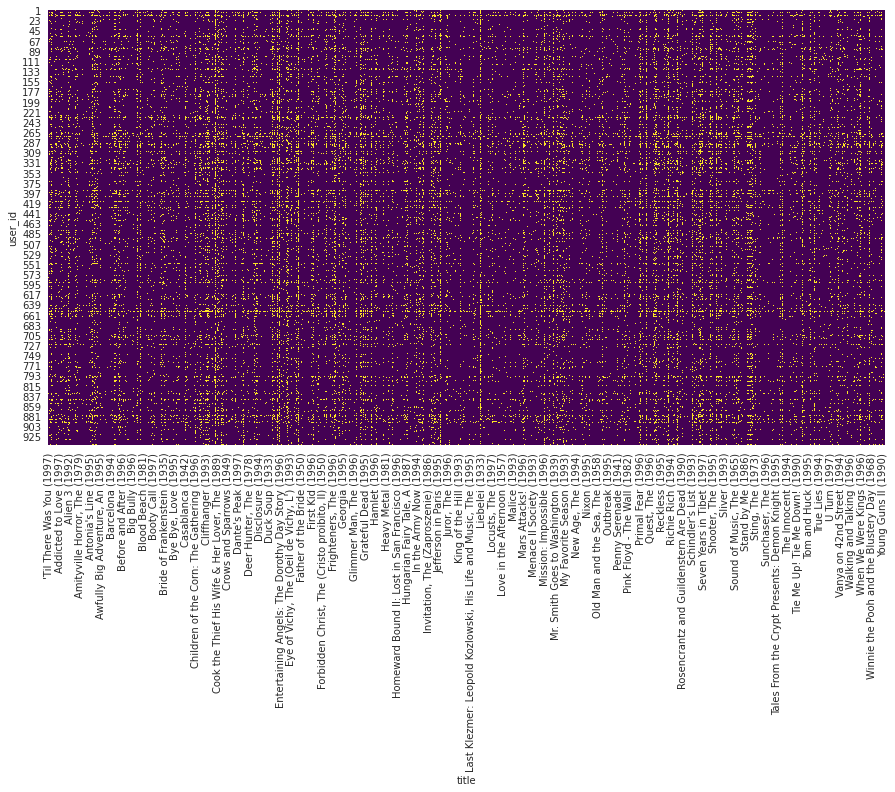

In [51]:
plt.figure(figsize=(15,8))
sns.heatmap(movie.notnull(), cmap='viridis', cbar=False)
plt.savefig('images/matrix.png', bbox_inches='tight', dpi=200);

Sitemas que levam em conta tanto características avaliativas quanto de atributos, são chamados de **Sistemas de recomendação híbridos**, onde a filtragem colaborativa e os modelos baseados em conteúdo são combinados. Estes sistemas de recomendação geralmente mostram maior precisão do que os modelos de filtragem colaborativa ou baseados em conteúdo separadamente, pois são capazes de resolver o problema de "partida a frio" melhor, já que se você não tiver nenhuma classificação para um usuário ou item, poderá usar metadados do usuário ou item para realizar uma previsão.

## SVD

Um método muito conhecido de decomposição de matrizes é a **decomposição em valores singulares** - *Singular value decomposition (SVD)*. É possível fazer uma aproximação da matriz de Filtragem Colaborativa `X`, usando SVD. Um caso de sucesso da utilização de SVD em sistemas de recomendação foi obtido pelo time vencedor da **Netflix Prize competition** [Netflix Prize and SVD](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf).

Matematicamente, a expressão geral de SVD é dada por:

 $$X=USV^T$$


Seja `X` a matriz com dimensões `m x n`, a matrix *`X`* pode ser fatorada em *`U`*, *`S`* e *`V`*, de modo que :
* *`U`* é uma matriz ortogonal *`(m x r)`*
* *`S`* é uma matriz diagonal com números reais não-negativos na diagonal *`(r x r)`*
* *$V^T$* é uma matriz ortogonal *`(r x n)`*

Elementos na diagonal de `S` são conhecidos como *valores singulares de`X`*. 


A matriz *`U`* representa vetores de características, correspondendo aos usuários no espaço dos atributos ocultos e *`V`* representa a matriz de vetores de características correspondendo aos itens no espaço de atributos oculto.

Finalmente, realizamos predições com o produto interno entre *`U`*, *`S`* e *$V^T$*.

In [52]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

Na escolha do valor de k para o svd truncado, é possível ver que o menor rmse é retornado para k igual a 13. Importante notar que não estamos utilizando um dado de teste. Aqui, apenas fazemos uso de treino e validação. O ideal seria utilizar um dado de teste para verificar a eficácia real do modelo em dados não vistos.

In [53]:
dic_rmse = {}

K = range(5, 30)
for k in K:
    u, s, vt = svds(train_data_matrix, k = k)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    dic_rmse[k] = rmse(X_pred, val_data_matrix)
    
sorted_dic = dict(sorted(dic_rmse.items(), key=lambda x:x[1]))
sorted_dic

{11: 2.673285484408235,
 10: 2.6732987187136175,
 12: 2.6734456900561314,
 13: 2.6747745634153413,
 9: 2.675481938169643,
 14: 2.6785194267677213,
 8: 2.683180004584293,
 15: 2.6844816362686204,
 16: 2.6861731565268583,
 17: 2.6920655429447975,
 7: 2.696817776841835,
 18: 2.6985563374374792,
 19: 2.7063218384941563,
 6: 2.7124980945289963,
 20: 2.714346814485524,
 21: 2.7229344051534414,
 22: 2.7322575177599115,
 5: 2.738743903002655,
 23: 2.739742496256713,
 24: 2.7473135728633546,
 25: 2.755448831706796,
 26: 2.7640206270761745,
 27: 2.77271902240837,
 28: 2.7795385594479978,
 29: 2.786683901063117}

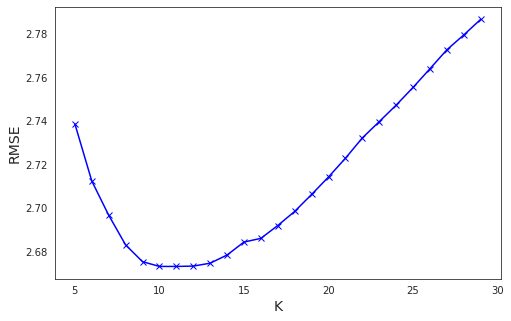

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(list(dic_rmse.keys()), list(dic_rmse.values()), 'bx-')
plt.xlabel('K', fontsize=14)
plt.ylabel('RMSE', fontsize=14);

Graficamente, conseguimos um valor baixo já para k = 10. Portanto, vamos utilizar esse valor.

In [55]:
#obtendo os componentes SVD da matriz de treino com valor ótimo de k.
u, s, vt = svds(train_data_matrix, k = 10)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('RMSE para FC baseada em usuário: ' + str(rmse(X_pred, val_data_matrix)))

RMSE para FC baseada em usuário: 2.673298718713617


Conseguimos reduzir consideravelmente o RMSE, fazendo uso de SVD!!!

### Quais filmes poderíamos indicar para o usuário de ID 20?

Este usuário parece gostar de filmes de Drama, seguido de comédia, ação e suspense

In [56]:
from sklearn.preprocessing import MinMaxScaler

### Colocando X_pred na escala entre 0 e 5

In [57]:
# Tornando valores negativos iguais a 0
X_pred[X_pred < 0] = 0

In [58]:
scaler = MinMaxScaler(feature_range=(0, 5))
X_pred_transformed = scaler.fit_transform(X_pred)

### Avaliações de todos os itens preditos para o usuário 20

In [59]:
X_pred_transformed[20,:]

array([1.4667422 , 0.        , 1.41582087, ..., 0.59885774, 0.37030229,
       0.        ])

Análise dos dados de treino para o usuário 20, de filmes avaliados com 4 ou 5 estrelas

Vamos agrupar os filmes por gênero e verificar quantos filmes fazem parte de cada gênero

In [60]:
nested = [a[i] for a in train_data[(train_data.user_id == 20) & (train_data.rating > 3)].sort_values('item_id').genero_string.values for i in range(len(a))]
count_genero = {j:nested.count(j) for j in nested}
count_genero

{'Drama': 7,
 'Action': 7,
 'War': 2,
 'Adventure': 5,
 'Sci-Fi': 2,
 'Thriller': 4,
 'Romance': 3,
 "Children's": 1,
 'Comedy': 2}

Preferências:
 - Ação
 - Drama, Aventura e suspense

### Posições dos itens preditos com avaliação superior a 3, para o usuário 20.

In [61]:
np.where(X_pred_transformed[20,:] > 3)[0]

array([ 369,  457,  978,  986, 1327, 1364, 1391])

In [62]:
df_unique = df[df.item_id.isin(np.where(X_pred_transformed[20,:] > 3)[0])].drop_duplicates(subset='item_id')

for i, row in df_unique.iterrows():
    print(row['title'],'\t', row['genero_string'], '\n')

Captives (1994) 	 ['Drama'] 

Free Willy 3: The Rescue (1997) 	 ['Adventure', "Children's", 'Drama'] 

Black Sheep (1996) 	 ['Comedy'] 

Bird of Prey (1996) 	 ['Action'] 

Heaven's Prisoners (1996) 	 ['Mystery', 'Thriller'] 

Turbulence (1997) 	 ['Thriller'] 

For Ever Mozart (1996) 	 ['Drama'] 



In [63]:
nested = [a[i] for a in df_unique.sort_values('item_id').genero_string.values for i in range(len(a))]
count_genero = {j:nested.count(j) for j in nested}
count_genero

{'Comedy': 1,
 'Adventure': 1,
 "Children's": 1,
 'Drama': 3,
 'Mystery': 1,
 'Thriller': 2,
 'Action': 1}

### Comclusões

Inicialmente, mostramos um sistema de recomendações bastante simplório, baseado em similaridades. A segunda tentativa foi filtragem colaborativa baseada em memória. Por fim, fizemos uso de Filtragem Colaborativa baseada em modelo, fazendo uso de Decomposição em Valores Singulares (SVD), que deu o melhor resultado. Mostramos ao fim, o uso deste modelo para recomendar filmes ao usuário de ID 20 e vimos que as indicações seguiram na direção da preferência do usuário, pois caem na categoria de drama, ação e suspense. Estranhamente, aparecem várias recomendações do gênero comédia.

Por fim, esse é apenas um estudo inicial. Ainda há outras técnicas avançadas, como por exemplo o uso de **wide and deep**. Além disso, pode-se utilizar outras variáveis como sexo e idade, que fazem parte dos metadados desta base de dados, mas que aqui não foram empregados.